# vMF-VAE modelling for new MCMCP (study2)

## What is von Mises-Fisher distribution?
> vMF is a kind of distribution over a (d-1)-dimentional hypersphere within a d-dimensional space, which could be a uniform distribution over the sphere, or a peak centered at any given vector \mu (with a parameter kappa controlling the variance). 

## Why I plan to replace the gaussian prior with von Mises-Fisher distribution?
* Origin gravity: Gaussian prior will push data towards the origin no matter what category it is;
> First, it makes no sense to encourage all categories to cluster in the center; then, this effect will cause imbalance distributions of different clusters, hindering the diversity of generation. 
* Hard to use uniform distribution in a hyper-plane space;
* vMF provide a grace solution to uniform facial affects, which could improve the representative ability of latent space;
* Emotions' distribution is theoretically 2-d with a potential Circumplex structure (Russell, 1980), lines up well with the vMF hypersphere;
* Put affect on 2-d manifold rather than 3-d space could ease both sampling process and space mapping.

## Why use 3-d latent space?
* I think we should stay with 3-d space (with 2-d sphere in it) because we need enough space to accomodate neutral and other faces, and also we can just estimate the density over the surface of hypersphere instead of the whole space where hypersphere is embedded in.

## What do the hyper-parameters mean and why to select specific values, like kappa particularly?
* The main concern in this model's training is to find a suitable kappa for 3-d vmf distribution which is big enough (the distribution become slimmer) for generator to learn face details (e.g., kappa=1 produces a generator that is able to generate an average face merely over the latent space, with a negative diversity, and hard to be seperated into different clusters as well --- high stickiness among the data), but also not too big to avoid reconstruting the facial identity information, making the model concentrate on the facial affect, and be continuous as well.
* Based on the current trials, k=300 with no matter how many epoches has the best performance.

## The vmf-VAE provides us a pure, continuous, finite facial-expression latent space, with good fidelity and diversity!
## The final question is, how to evaluate the model (not important but necessary) --- FID

In [1]:
! nvidia-smi
! nvcc -V

Fri Oct 13 21:43:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.103                Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060        On  | 00000000:09:00.0  On |                  N/A |
|  0%   42C    P8              23W / 170W |   1357MiB / 12288MiB |     13%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import os
import sys
import gc
import numpy as np
import torch
from torchsummary import summary
from torch.cuda.amp import GradScaler, autocast
from utils import accuracy_cafe, accuracy_fer, accuracy_res, setup_seed, latent_space, manifold_sphere, reconstruction, latent_sample, EarlyStopping
from train import train
from transfer import transfer
from finetune import finetune
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import pi

from dataset_cafe import get_cafeloaders
from dataset_jaffe import get_jaffeloaders
from dataset_fer2013 import get_dataloaders
import models
from torchvision.transforms import Resize

In [2]:
class config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # distribution_id = 'normal' # or normal
    distribution_emo = 'normal' # or normal
    # latent_dim_id = 2  # determine shape of latent space, 2 or 3
    latent_dim_emo = 3  # determine shape of latent space, 2 or 3
    radius = 5  #controlling the radius of the hypersphere or the gaussian
    kappa = 300  # enough details but not too much, set as 500 according to the area of recontructive sampling

    data_path = "./data/cafe/balance_all"  # "./data/jaffe"
    image_size = (64, 40)  # determine the raw size before transform: (40, 40) or (64, 40) or (48, 40)
    label_list = {'0':'Angry', '1':'Disgust', '2':'Fear', '3':'Happy', '4':'Sad', '5':'Surprise', '6':'Neutral'}

    weight_recon =  0.55 #  1 - alpha
    # weight_class_id = 0  # weight of classfier loss
    weight_class_emo = 1 - weight_recon
    
    aug = False
    Ncrop = False 
    if Ncrop:
        batchsize = 16  # with Ncrop = 5
    elif not Ncrop:
        batchsize = 128
    else:
        raise NotImplemented
    
    loss = torch.nn.MSELoss  
    # "MSELoss" or "BCEWithLogitsLoss", when use BCEWithLogitsLoss, sigmoid af in the end of decoder should be removed!!
    n_epoch = 200
    transfer_epoch = 200
    learning_rate = 1e-3
    scheduler = None  # learning rate schedule, "reduce", None ...
    saved_path = "./saved_models/"
    
print(config.device)
setup_seed(13)

cuda


In [3]:
# data
# Kfold = "3/5"
# valid_loader = get_jaffeloaders(path=config.train_path, 
#                                bs=config.batchsize, 
#                                augment=config.aug, input_size=config.image_size)
train_loader = get_cafeloaders(path=config.data_path, 
                               bs=config.batchsize, 
                               augment=config.aug, input_size=config.image_size, 
                               k_fold=None)
_, valid_loader, test_loader = get_dataloaders(path='data/fer2013/fer2013.csv', bs=128)

### Try VGG first

In [14]:
model = models.Vgg()
checkpoint = torch.load("models/VGGNet")
model.load_state_dict(checkpoint['params'])
model = model.to(config.device)

In [15]:
model.eval()
positive_pred = 0
amount = 0

for data in train_loader: 
    base_images, base_images_id, labels, labels_id = data
    
    base_images, labels= base_images.to(config.device), labels.to(config.device)
    # base_images_id, labels_id= base_images_id.to(config.device), labels_id.to(config.device)
    
    labels_emo_ = model(Resize((40, 40))(base_images))
    positive_pred += torch.sum(torch.argmax(labels_emo_, dim=1, keepdim=False) == labels)
    amount += len(labels)

accuracy = positive_pred.cpu().numpy() / amount
accuracy

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0.14166666666666666

### combine the resnet

In [4]:
resnet18 = models.ResNet18()
# print(resnet18)
checkpoint = torch.load("models/best_checkpoint.tar")  # best_checkpoint.tar
# model.load_state_dict(checkpoint['params'])
resnet18.load_state_dict(checkpoint['model_state_dict'])
resnet18 = resnet18.to(config.device)

vae = models.VAE(z_dim=config.latent_dim_emo,
                 distribution=config.distribution_emo,
                 kappa=config.kappa, 
                 radius=config.radius, 
                 device=config.device).to(config.device)

In [33]:
accuracy_res(resnet18, test_loader, config)

0.7241571468375592

In [5]:
class resVAE(torch.nn.Module):
    def __init__(self, submodel1, submodel2):
        super(resVAE, self).__init__()
        self.submodel1 = submodel1
        self.submodel2 = submodel2
 
    def forward(self, x):
        _, x = self.submodel1(x)
        (z_mean, z_var), (q_z, p_z), z, (x_rec, x_cla) = self.submodel2(x)
        
        return (z_mean, z_var), (q_z, p_z), z, (x_rec, x_cla)

resnetVAE = resVAE(resnet18, vae)

### training

In [6]:
for p in resnetVAE.parameters():
    p.requires_grad = False
for i,p in enumerate(resnetVAE.parameters()):
    if i > 61:
        p.requires_grad = True
for name, param in resnetVAE.named_parameters():
    if param.requires_grad:
        print(name)

submodel2.fc_mean.weight
submodel2.fc_mean.bias
submodel2.fc_var.weight
submodel2.fc_var.bias
submodel2.fc_de0.weight
submodel2.fc_de0.bias
submodel2.fc_de1.weight
submodel2.fc_de1.bias
submodel2.Tcov_de2.weight
submodel2.Tcov_de2.bias
submodel2.Tcov_de3.weight
submodel2.Tcov_de3.bias
submodel2.Tcov_de4.weight
submodel2.Tcov_de4.bias
submodel2.linear.weight
submodel2.linear.bias


Epoch  1/200: RC_loss   6.289, KL_loss  35.290, CL_loss_emo1864.037, acc_in_fer   0.233, acc_in_cafe   0.276
Validation measure (inf --> 0.232655).  Saving model ...
Epoch  2/200: RC_loss   6.181, KL_loss  35.296, CL_loss_emo1853.006, acc_in_fer   0.311, acc_in_cafe   0.311
Validation measure (0.232655 --> 0.311229).  Saving model ...
Epoch  3/200: RC_loss   6.034, KL_loss  35.311, CL_loss_emo1841.511, acc_in_fer   0.419, acc_in_cafe   0.439
Validation measure (0.311229 --> 0.418780).  Saving model ...
Epoch  4/200: RC_loss   5.724, KL_loss  35.345, CL_loss_emo1829.210, acc_in_fer   0.430, acc_in_cafe   0.455
Validation measure (0.418780 --> 0.429646).  Saving model ...
Epoch  5/200: RC_loss   5.176, KL_loss  35.387, CL_loss_emo1816.747, acc_in_fer   0.432, acc_in_cafe   0.454
Validation measure (0.429646 --> 0.431875).  Saving model ...
Epoch  6/200: RC_loss   4.634, KL_loss  35.429, CL_loss_emo1804.447, acc_in_fer   0.432, acc_in_cafe   0.455
Validation measure (0.431875 --> 0.432432

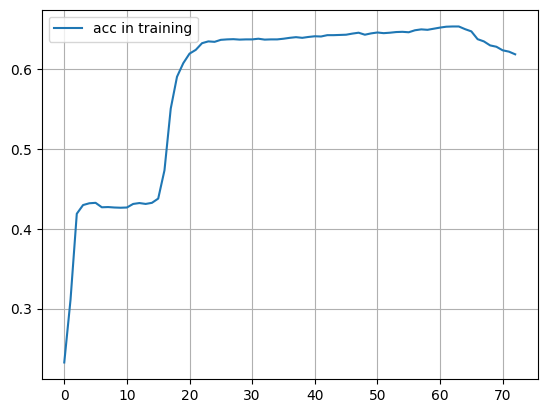

In [7]:
# optimizer
optimizer = torch.optim.Adam([p for p in resnetVAE.parameters() if p.requires_grad == True], lr=config.learning_rate, betas=(0.9, 0.99))
# amp: automatic mixed precision training 
scaler = GradScaler()  
# scheduler to adjust the learning rate
if config.scheduler == 'reduce':
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=False)

# training process trend monitor
accuracy_list = []

earlystop = EarlyStopping(patience=10, verbose=True, path='saved_models/early_cp_seed=13_w=55_var=5_svar=0.3_noKL_bs128.pt')

for epoch in range(config.n_epoch):
    rec_loss, kl_loss, cla_loss = train(resnetVAE, train_loader, optimizer, scaler, config) 
    
    if config.scheduler == 'reduce':
        scheduler.step(rec_loss + cla_loss/250)
        
    acc = accuracy_fer(resnetVAE, valid_loader, config)
    acc_train = accuracy_cafe(resnetVAE, train_loader, config)
    accuracy_list.append(acc)

    print("Epoch%3d/%3d: RC_loss%8.3f, KL_loss%8.3f, CL_loss_emo%8.3f, acc_in_fer%8.3f, acc_in_cafe%8.3f" 
          % (epoch+1, config.n_epoch, rec_loss, kl_loss, cla_loss, acc, acc_train))
    # print("=====XXX=====")
    earlystop(acc, "max", resnetVAE)
    if earlystop.early_stop:
        break

    # finish the train
#     if acc > 0.7:
#         model_name = f"test_{epoch+1}.pt"
#         torch.save(resnetVAE, config.saved_path + model_name)
#         print("model has been saved as:", config.saved_path + model_name)
#         break


# training process trend monitor
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(accuracy_list, color='tab:blue', label="acc in training")
# ax.vlines(len(loss_reconstruction)-config.finetune_epoch-1, 0, 10, linestyles='dashed', colors='yellow', label="start the decoder-finetune")
plt.grid()
plt.legend()
plt.show()

### vasualization

In [7]:
model_name = "early_cp_seed=13_w=55_var=5_svar=0.3_noKL_bs128.pt"  # "k30_e50, k35_e50, k35_e50(2d), k35_e80(2d), k35_e80_w3(2d), k35_e80_w3(2d_40x40), k40_e80, k300_e50_v2"
model = torch.load(config.saved_path + model_name)

In [8]:
accuracy_fer(model, test_loader, config)

0.6363889662858735

In [9]:
accuracy_cafe(model, train_loader, config)

0.6635416666666667

Number of data: 960


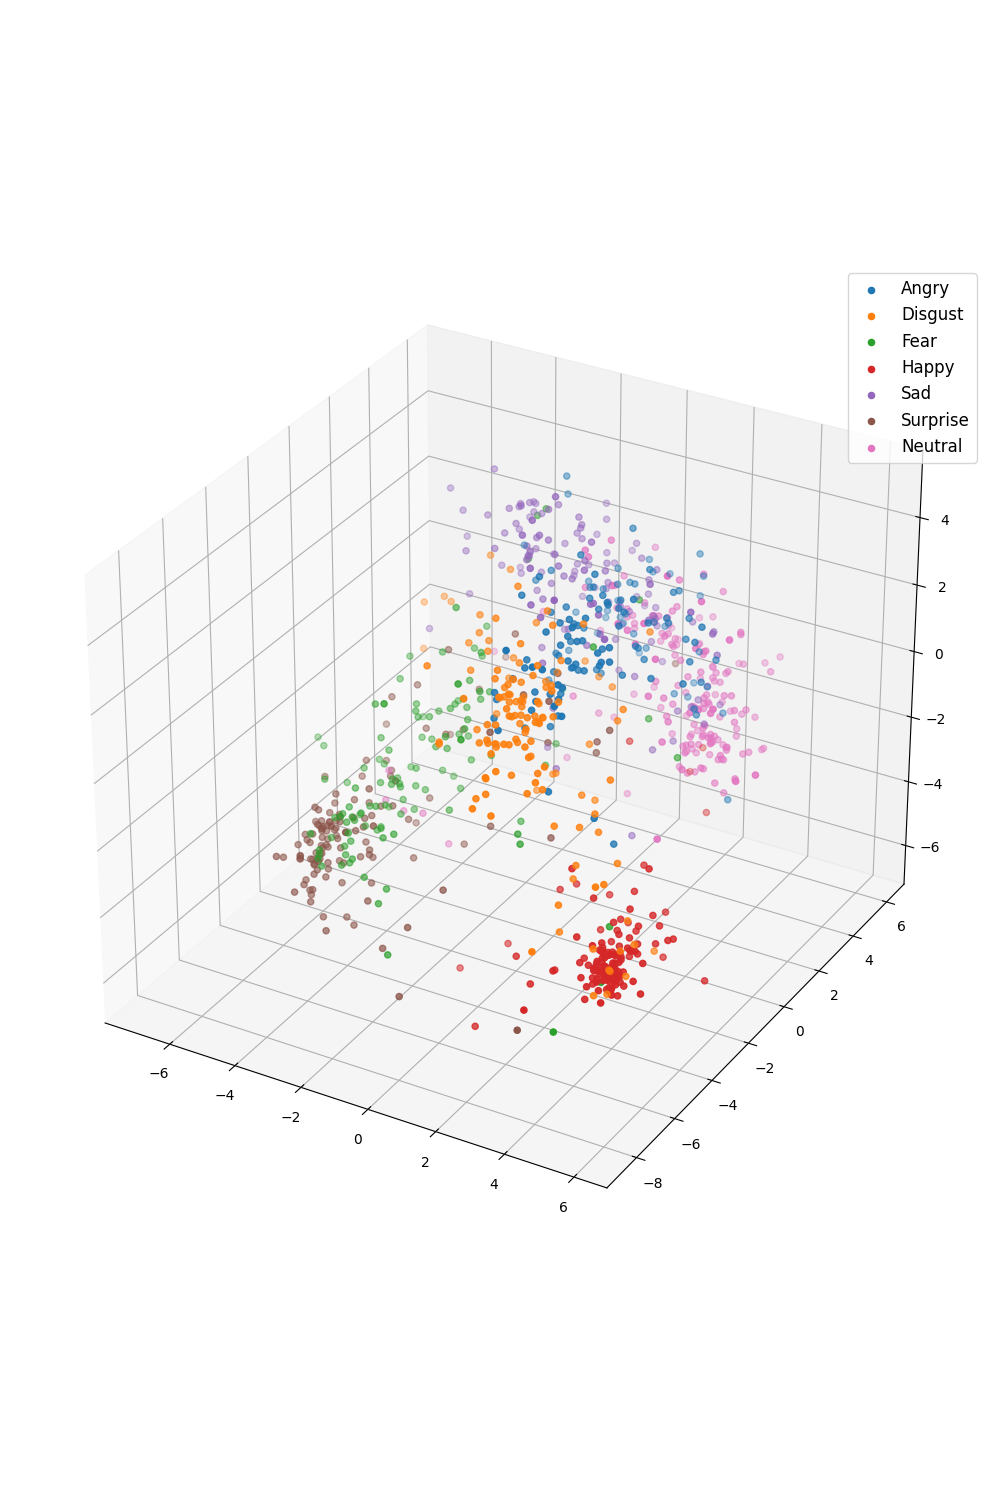

In [10]:
%matplotlib widget
latent_space(model, train_loader, config, legend=True)

In [18]:
plt.close()

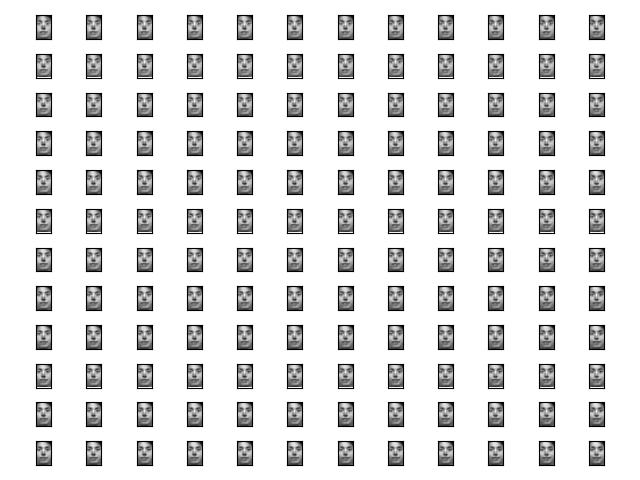

In [16]:
xy_resolution = 15
manifold_sphere(model.submodel2, config,
                theta=list(b*pi for b in np.linspace(0, 2, xy_resolution)), 
                z_resolution=12, # z_resolution works only when z_dim=3
                z=-15
               )  # theta belons to the range 0-2pi

In [ ]:
xy_resolution = 20
conditional_manifold(model, "emo", torch.tensor([[5.6, -9.3]]), config, 
                theta=list(b*pi for b in np.linspace(0, 2, xy_resolution)), 
                z_resolution=20, # z_resolution works only when z_dim=3
               )  # theta belons to the range 0-2pi

In [20]:
reconstruction(resnetVAE, train_loader, n_show=10, config=config)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1024 and 512x7)

In [ ]:
len(train_loader)

In [10]:
latent_sample(model, config)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x3 and 6x128)

In [88]:
from hypersphere.distributions import VonMisesFisher
%matplotlib widget 

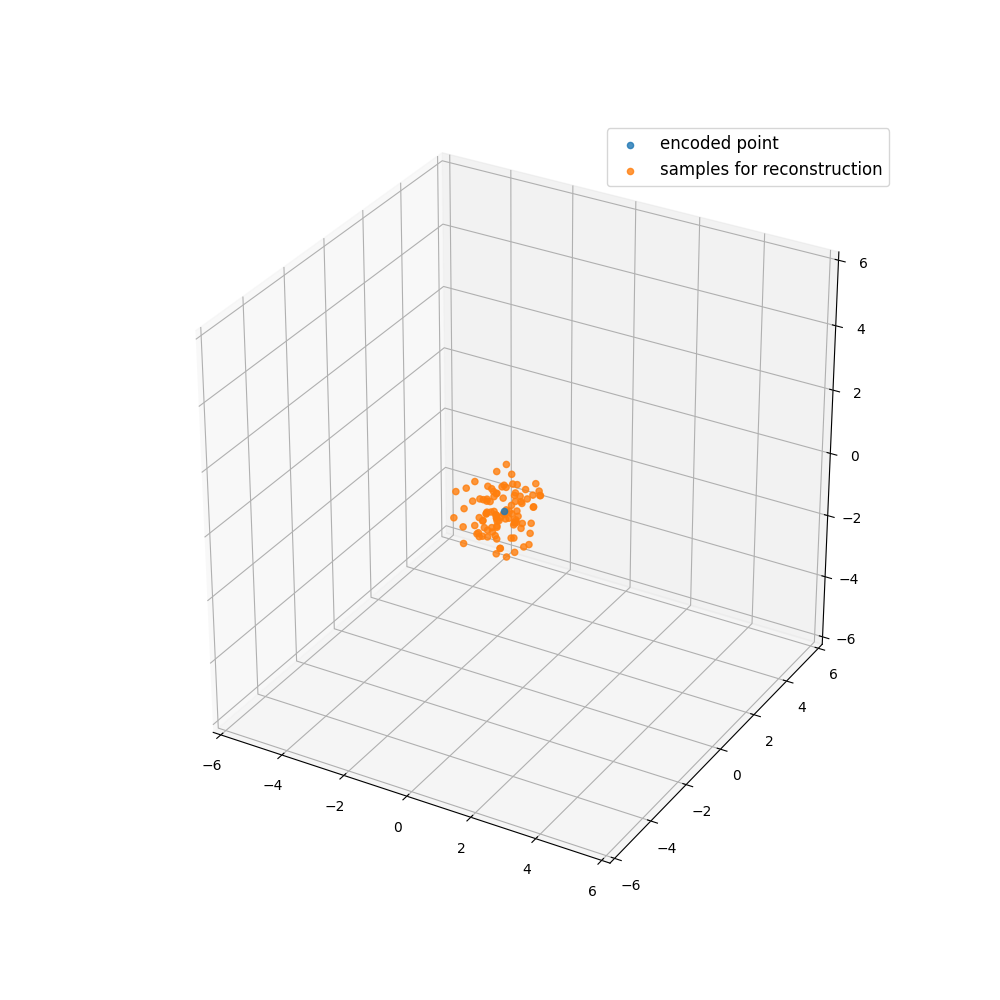

In [98]:
center = np.array([0, -1, 0])
samples = np.random.multivariate_normal(center, np.eye(3)*0.3, 100)
# print(samples)
ax = plt.figure(figsize=(10, 10)).add_subplot(111, projection='3d', computed_zorder=False)

# # Make data
# u = np.linspace(0, 2 * np.pi, 100)
# v = np.linspace(0, np.pi, 100)
# x = np.outer(np.cos(u), np.sin(v))
# y = np.outer(np.sin(u), np.sin(v))
# z = np.outer(np.ones(np.size(u)), np.cos(v))

# # Plot the surface
# ax.plot_surface(x, y, z, zorder=-1, alpha=0.5, color="white")
# Set an equal aspect ratio
ax.set_aspect('equal')

ax.scatter(center[0],
           center[1],
           center[2],
           alpha=0.8, label="encoded point", zorder=999)
ax.scatter(samples[:, 0],
           samples[:, 1],
           samples[:, 2],
           alpha=0.8, label="samples for reconstruction")

ax.legend(fontsize=12)
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ax.set_zlim(-6, 6)
plt.show()

In [87]:
plt.close()

In [23]:
from math import pi, atan2, asin, sqrt
import numpy as np